<a href="https://colab.research.google.com/github/opherdonchin/Grades-for-projects-anonymized/blob/main/Regression_analysis_posters_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for separating project grades from influence of grader

## Short description

Lots of projects. Lots of graders. Each grader, lots of sub-grades. Put them all together in a model

I built this using the outline in this page: [Bayesian Linear Regression Using PyMC3](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

## Imports and setup for google colab

### Imports setup environment for google colab

If you are not working under google colab, you can setup the environment by installing [miniforge](https://github.com/conda-forge/miniforge) (if you don't already have mamba/conda installed) and running:

`mamba env create ProjectGrades -f ProjectGrades.yaml`

and then

`mamba activate ProjectGrades`

In a miniforge/conda terminal. 


`condacolab` sets up a mamba/conda environment inside google colab. You can find a further description [here](https://pypi.org/project/condacolab/) or a colab notebook with example code [here](https://colab.research.google.com/drive/1c_RGCgQeLHVXlF44LyOFjfUW32CmG6BP#scrollTo=LAZ11nESX6qt).

*Importantly*, do not **run all** just yet! Run this first cell first on its own. That will set up google colab and restart the Python server. At that point, you can run all.

In [21]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install pymc &> /dev/null
  !pip install xlsxwriter

  from pathlib import Path
  %cd /content
  if not Path("Grades-for-projects-anonymized").is_dir():
    !git clone https://github.com/opherdonchin/Grades-for-projects-anonymized
  %cd /content/Grades-for-projects-anonymized

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 8.3 MB/s 
/content
/content/Grades-for-projects-anonymized


In [2]:
%env MKL_THREADING_LAYER=GNU

env: MKL_THREADING_LAYER=GNU


In [3]:
# Imports
# Python
import platform
import os.path
import pickle
import chardet

# Maths
import numpy as np
import pandas as pd
import scipy.stats as stats

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Bayes
import xarray as xr
import aesara
import aesara.tensor as tt
import pymc as pm
import arviz as az

az.style.use("arviz-darkgrid")


In [4]:
print('Running on the PyMC3 v{}'.format(pm.__version__))


Running on the PyMC3 v4.0.1


### Load data

In [5]:
data_directory = os.path.join('.','data')
base_name = 'posters 2022'
url_raw_data = os.path.join(data_directory, 'grades '+base_name+'.csv')

with open(url_raw_data, 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large
    
raw_data = pd.read_csv(url_raw_data, encoding = enc['encoding'], sep=",", on_bad_lines='skip')



In [6]:
raw_data.head()

,Project,Judge,Grade
0,205375215,Judge 13,97
1,205375215,Judge 17,94
2,205375215,Judge 5,100
3,208203521,Judge 1,88
4,208203521,Judge 9,88


### Preprocess data

In [7]:
data = raw_data.rename(columns = {'Project':'project', 'Judge':'judge', 'Grade':'grade'})


data['p_idx'], project_cats = pd.factorize(data['project'], sort=True)
data['j_idx'], judge_cats = pd.factorize(data['judge'], sort=True)

print(data.head())
data['grade'].describe()

     project     judge  grade  p_idx  j_idx
0  205375215  Judge 13     97      2      4
1  205375215  Judge 17     94      2      8
2  205375215   Judge 5    100      2     11
3  208203521   Judge 1     88      9      0
4  208203521   Judge 9     88      9     15


count     69.000000
mean      88.347826
std        8.436312
min       64.000000
25%       85.000000
50%       90.000000
75%       94.000000
max      100.000000
Name: grade, dtype: float64

## Model definition and fitting

### Define model

In [8]:
model_name = 'default'
def regression_model(p_idx, j_idx, grade, p_cats, j_cats):
  mu_mu0 = 85
  sd_mu0 = 10
  sd_mus = 10
  # sd_muj = 10
  sd_sd_muj = 7
  sd_sd_g_sigma = 15
  # lambda_j_nu = 1/10

  coords = {"projects": p_cats, "judges": j_cats, "measures":np.arange(len(grade))}
  with pm.Model(coords=coords) as model:
    # Data
    p = pm.Data("project", p_idx, dims=["measures"])
    j = pm.Data("judge", j_idx, dims=["measures"])

    # Priors
    # j_nu = pm.Exponential("j_nu", lam=lambda_j_nu)
    j_nu = pm.ConstantData("j_nu", 2)
    sd_muj = pm.HalfNormal("sd_muj", sigma=sd_sd_muj)
    mu_0 = pm.Normal('mu_0', mu=mu_mu0, sigma=sd_mu0)
    mu_p = pm.Normal('mu_p', mu=0, sigma=sd_mus, dims=["projects"])
    mu_j = pm.StudentT('mu_j', mu=0, sigma=sd_muj, nu=j_nu, dims=["judges"])

    # Regression variables
    g_mu = pm.Deterministic('g_mu', mu_0 + mu_p[p] + mu_j[j], dims=["measures"])
    g_sigma = pm.HalfNormal('g_sigma', sigma=sd_sd_g_sigma)
    
    # Likelihood 
    pm.Normal('g_obs', mu=g_mu, sigma=g_sigma, observed=grade, dims=["measures"])
  return model


### Show model

/usr/local/lib/python3.7/dist-packages/pymc/data.py:672: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  FutureWarning,


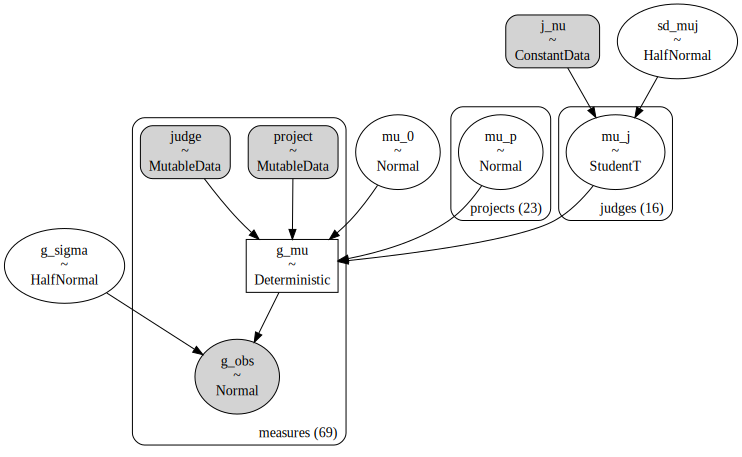

In [9]:
model = regression_model(data.p_idx, data.j_idx, data.grade, project_cats, judge_cats)
pm.model_to_graphviz(model)

### Sample model
Load samples from file if they are already there

In [10]:
trace_path = os.path.join('samples', 'samples ' + base_name + ' ' + model_name)
model_description = f'your model'
if not os.path.isfile(trace_path):
  print(f'Resampling {model_description}')
  model = regression_model(data.p_idx, data.j_idx, data.grade, project_cats, judge_cats)
  with model:
    idata = pm.sample(draws=5000, tune=4000, cores=5, target_accept=0.999, return_inferencedata=True)  
  print(f'Saving samples to {trace_path}')
  az.to_netcdf(idata, trace_path)
else:
  print(f'Loading samples for {model_description} from {trace_path}')
  idata = az.from_netcdf(trace_path)



Resampling your model


/usr/local/lib/python3.7/dist-packages/pymc/data.py:672: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  FutureWarning,
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [sd_muj, mu_0, mu_p, mu_j, g_sigma]


Sampling 5 chains for 4_000 tune and 5_000 draw iterations (20_000 + 25_000 draws total) took 1316 seconds.


Saving samples to samples/samples posters 2022 default


## Diagnostics

### Show traces

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47a1f87cd0>,
      dtype=object)

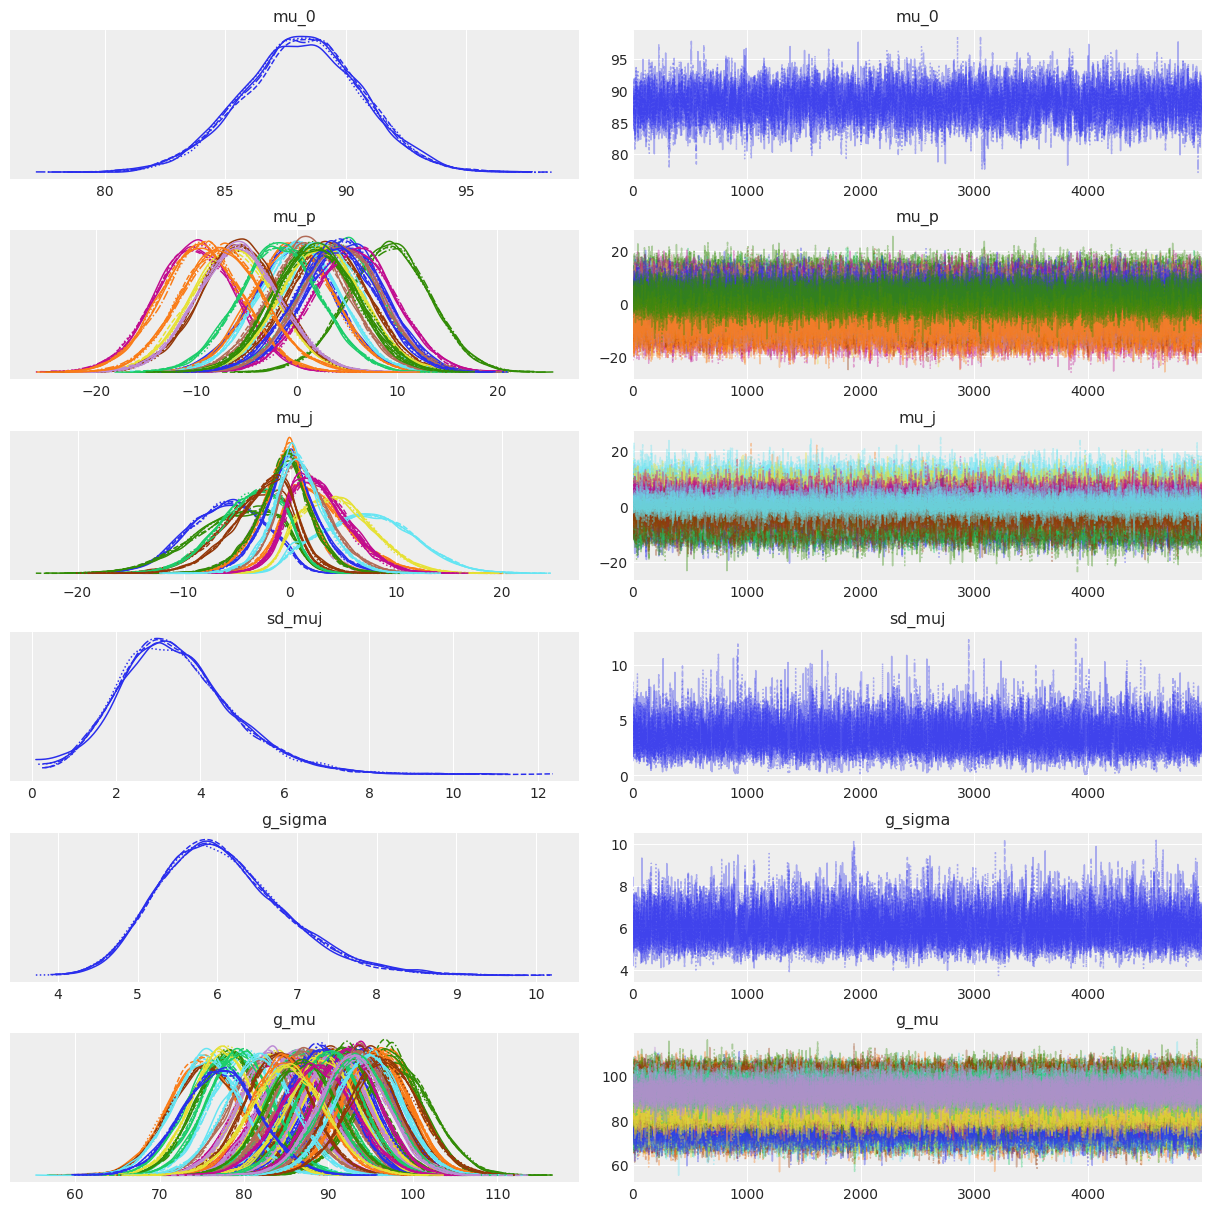

In [11]:
az.plot_trace(idata)

### Plot pairs

In [12]:
post = idata.posterior
keep_judges = [0, 1]
keep_projects = [0, 1]

judge_coords = post.coords['judges']
project_coords = post.coords['projects']

judge_mu_dict = {f'mu_{judge_coords[j].item()}': post['mu_j'][:,:,j] for j in keep_judges}
# judge_s_dict = {f'sd_{judge_coords[j].item()}': post['g_sigma'][:,:,j] for j in keep_judges}
project_dict = {f'mu_{project_coords[p].item()}': post['mu_p'][:,:,p] for p in keep_projects}

plot_data = az.from_dict(
    posterior = {'mu_0': post['mu_0'], 'g_sigma': post['g_sigma'], 'sd_muj': post['sd_muj'], **judge_mu_dict, **project_dict},
    sample_stats = {'diverging': idata.sample_stats.diverging}
)

/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:194: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4796f3b690>,
      dtype=object)

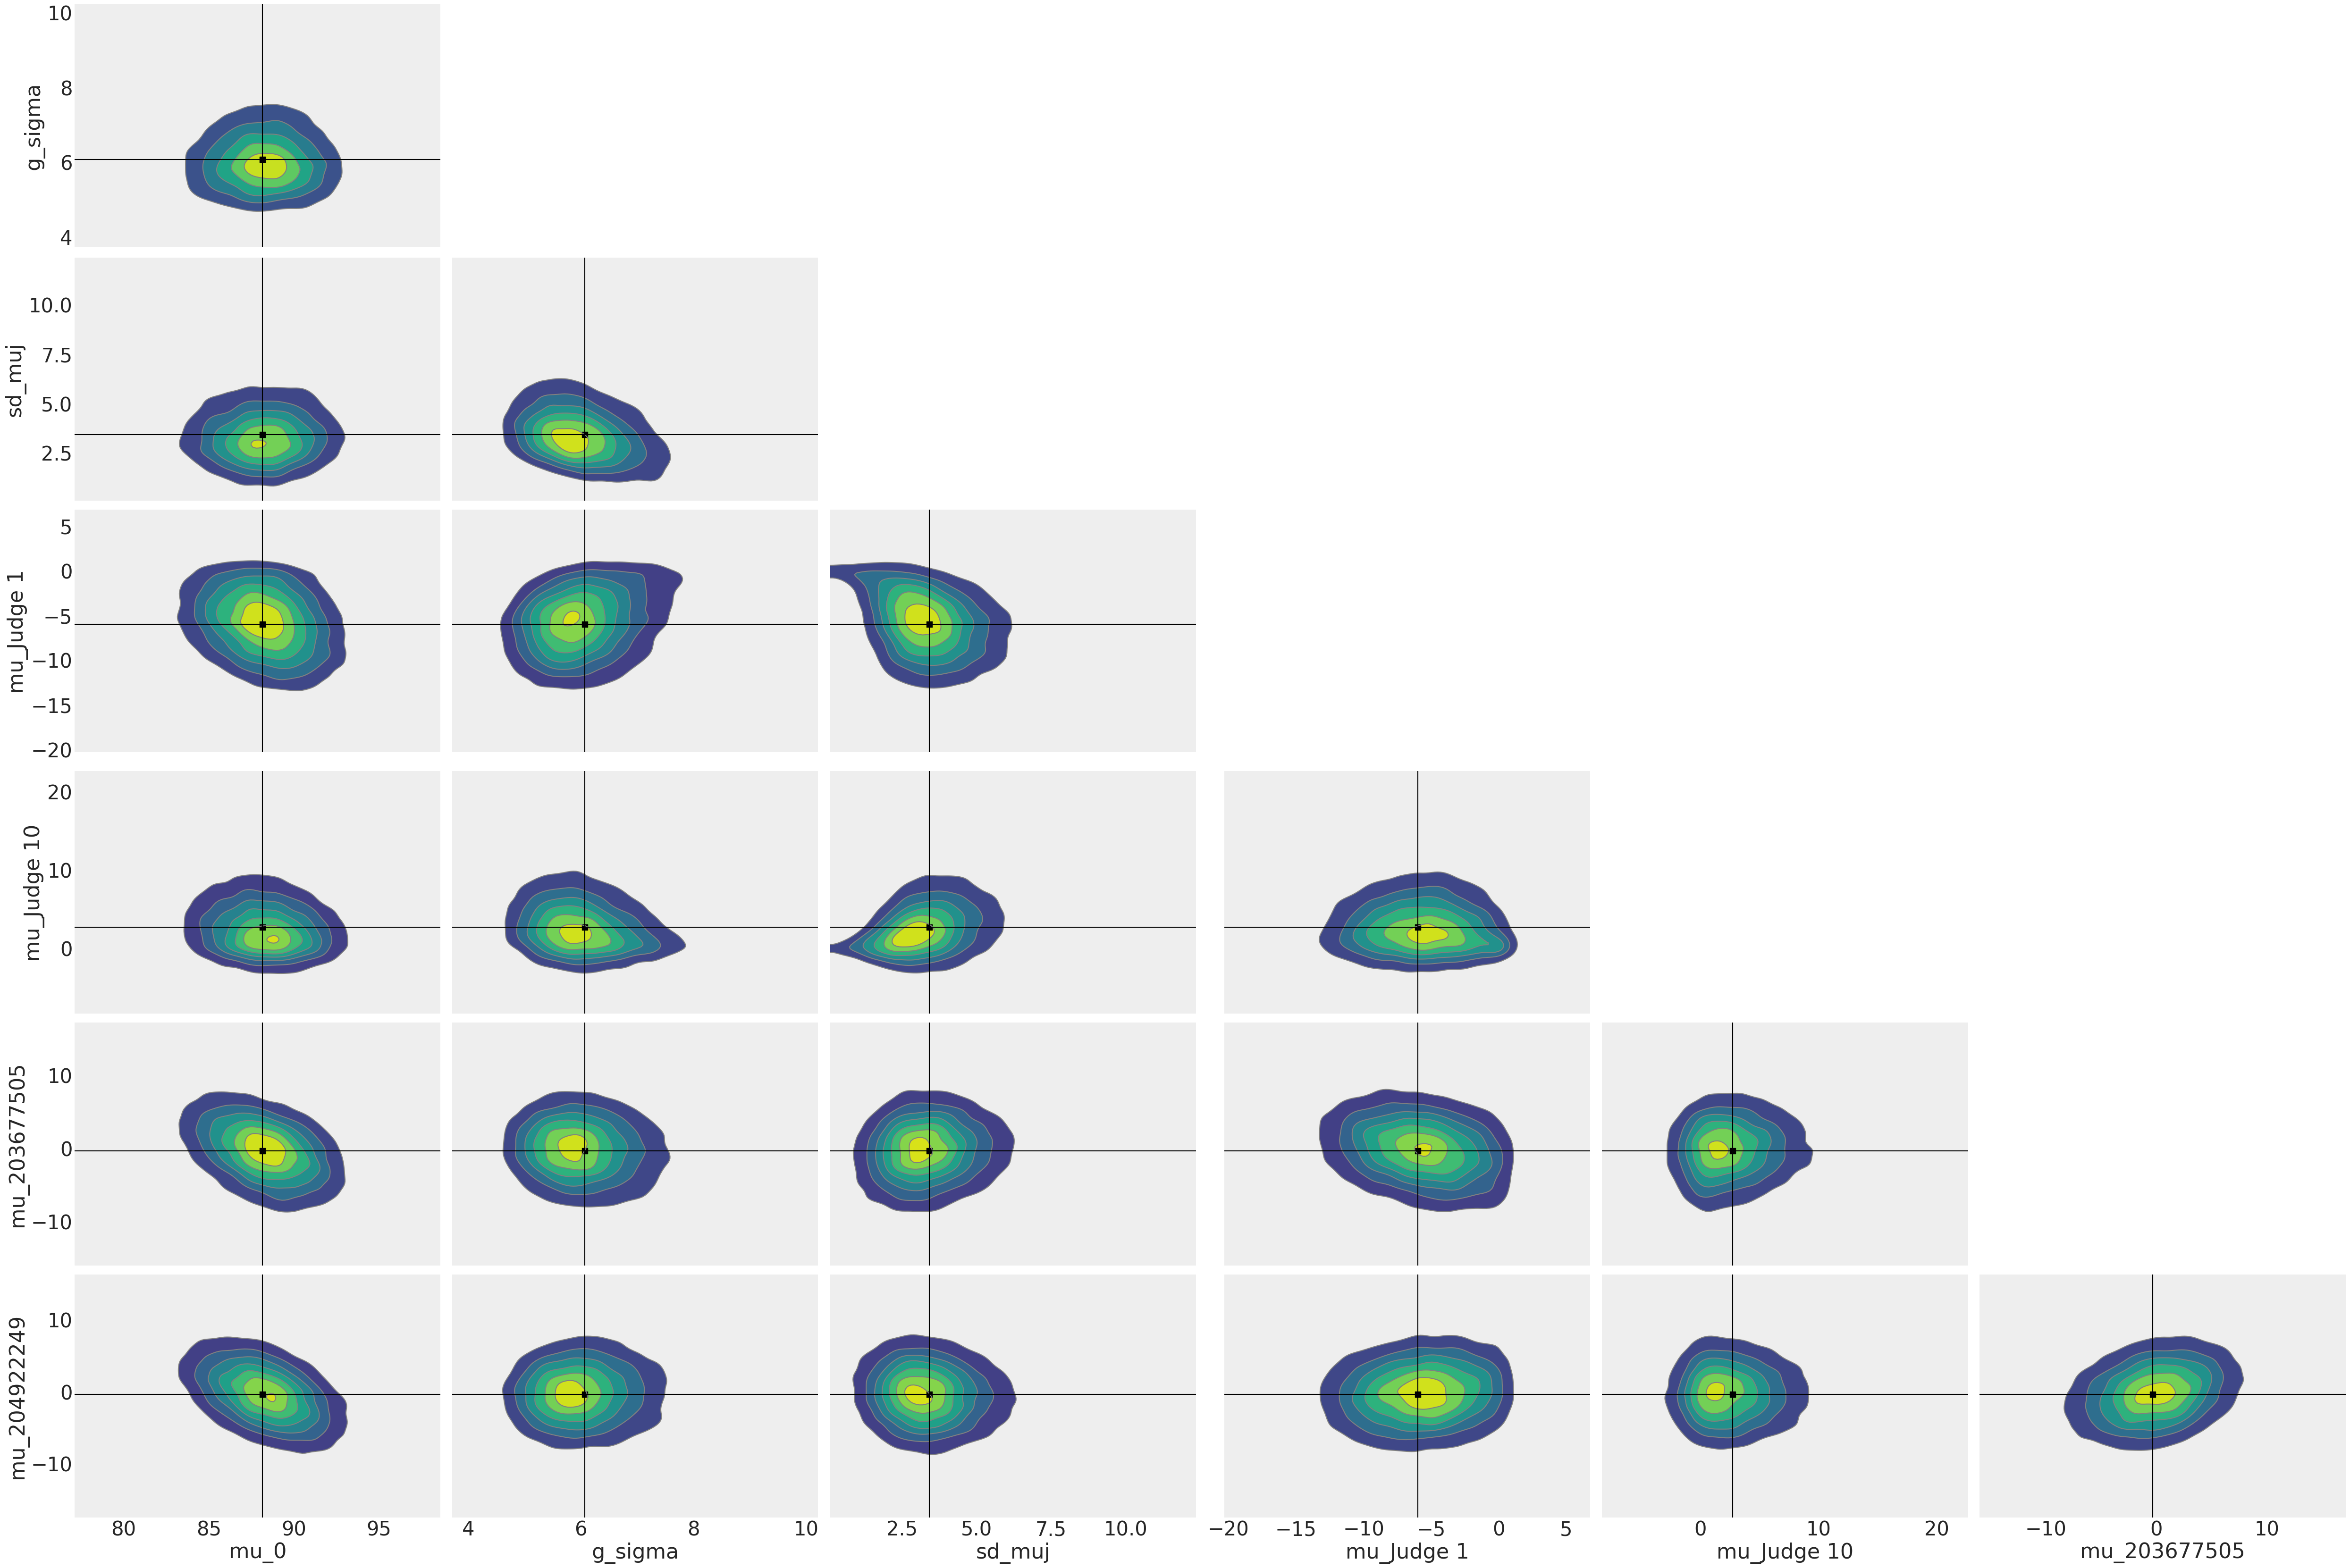

In [13]:
az.plot_pair(plot_data, kind='kde', contour=True, divergences=True, point_estimate='mean', textsize=30)

## Show results

### Plot judge means and estimates

Text(0.5, 1.0, 'Data mean and corrected value for each judge')

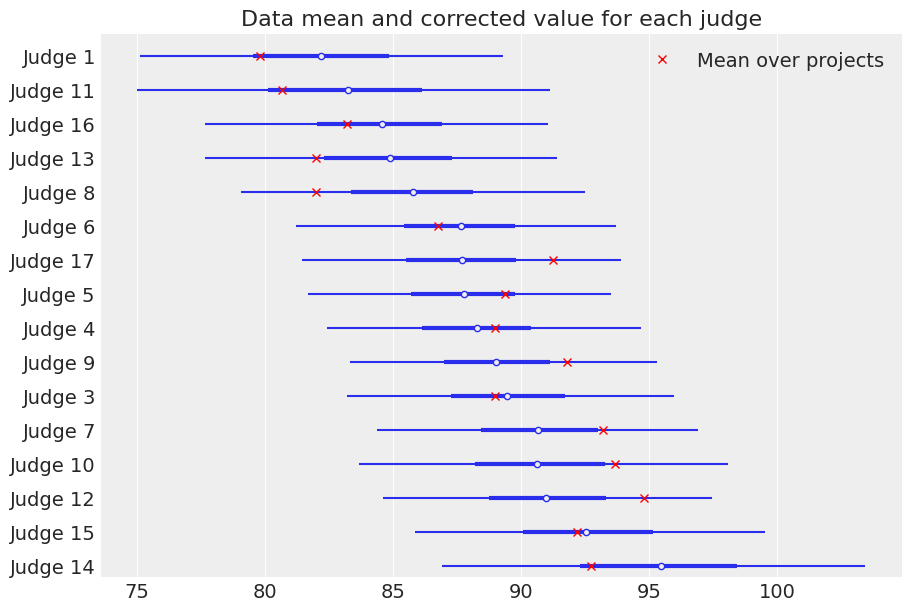

In [14]:
post = idata.posterior
mu_j = post['mu_j']
mu_0 = post['mu_0']

mu_j_mean = mu_j.mean(dim=['chain','draw'])
sort_order = mu_j_mean.argsort()

judge_coords = post.coords['judges']

mu_j_dict = {f'{judge_coords[j.item()].item()}': mu_j[:,:,j]+mu_0 for j in sort_order}

plot_data = az.from_dict(
    posterior = mu_j_dict,
    sample_stats = {'diverging': idata.sample_stats.diverging}
)
ax = az.plot_forest(plot_data, kind='forestplot', combined=True, figsize=[9, 6])

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.judge
xbar_j = [g_data[j_data==j].mean() for j in sort_order.to_numpy()]

y_vals = [li.get_data()[1].item() for li in ax[0].get_lines()]
y_vals = y_vals[::-1]


plt.plot(xbar_j, y_vals, linestyle='None', marker='x', color='r', label='Mean over projects')
ax[0].legend()
ax[0].set_title('Data mean and corrected value for each judge')


### Plot projects means and estimates
There are two ways to do this. 

1. Add the estimated mean to the estimated project to get a value that leaves out the judges
2. Subtract the judge mean from the scores to get a corrected score per project

The difference comes fom whether we keep the unexplained variance or discard it. Keeping it will bring up the score of teh worst project and bring
down the score of the best project. 

The current plot shows both.

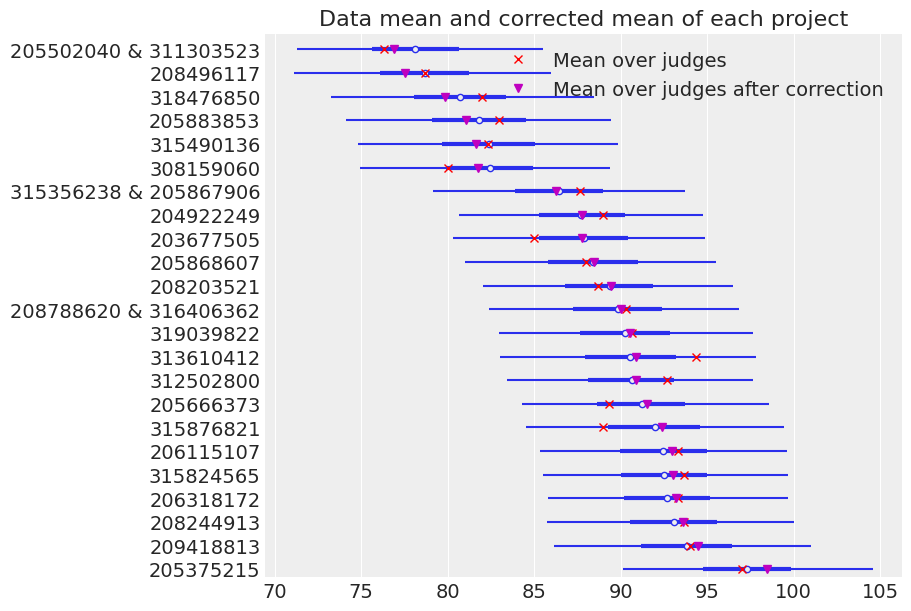

In [15]:
post = idata.posterior
mu_p = post['mu_p']
mu_0 = post['mu_0']

project_coords = post.coords['projects']
reversed_names = [c.item() for c in project_coords]

mu_p_mean = mu_p.mean(dim=['chain','draw'])
sort_order = mu_p_mean.argsort()
mu_p_dict = {f'{reversed_names[p.item()]}': mu_p[:,:,p]+mu_0 for p in sort_order}

plot_data = az.from_dict(
    posterior = mu_p_dict,
    sample_stats = {'diverging': idata.sample_stats.diverging}
)
ax = az.plot_forest(plot_data, kind='forestplot', combined=True, figsize=[9, 6])
ax[0].set_title('Offsets of the different projects')

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.judge
p_data = idata.constant_data.project

xbar_p = [g_data[p_data==p].mean() for p in sort_order.to_numpy()]

g_data_corrected = g_data-mu_j_mean.to_numpy()[j_data]
xbar_p_corrected = [g_data_corrected[p_data==p].mean() for p in sort_order.to_numpy()]

y_vals = [li.get_data()[1].item() for li in ax[0].get_lines()]
y_vals = y_vals[::-1]


plt.plot(xbar_p, y_vals, linestyle='None', marker='x', color='r', label='Mean over judges')
plt.plot(xbar_p_corrected, y_vals, linestyle='None', marker='v', color='m', label='Mean over judges after correction')
ax[0].set_title('Data mean and corrected mean of each project')
ax[0].legend()


### Make a table of the different judges

For each judge, the table will show the projects that they judged along with their grade for that project, then the straight average of all 
the judges, then our estimated grade, and finally their grade for this project corrected by our estimated correction for them.

In [16]:
post = idata.posterior
mu_j = post['mu_j']
sigma_g = post['g_sigma']
mu_p = post['mu_p']
mu_0 = post['mu_0']

mu_j_mean = mu_j.mean(dim=['chain','draw'])
sigma_g_mean = sigma_g.mean(dim=['chain', 'draw'])
mu_p_mean_score = (mu_0 + mu_p).mean(dim=['chain', 'draw'])
sort_order_j = mu_j_mean.argsort()
sort_order_p = mu_p_mean.argsort()

judge_coords = post.coords['judges']
project_coords = post.coords['projects']

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.judge
p_data = idata.constant_data.project

# Data means for judges and projects
xbar_j = [g_data[j_data==j].mean() for j in sort_order_j]
xbar_p = [g_data[p_data==p].mean() for p in np.arange(len(project_coords))]



max_proj = 0
df_rows = list()
titles = ['Judge', 'Correction']
for j_i in sort_order_j:
    j = judge_coords[j_i]
    j_name = judge_coords[j_i].item()
    j_mu = mu_j_mean[j_i].item()
    row = [j_name] # Judge name
    row.append(j_mu)
    
    for i,p in enumerate(p_data[j_data==j_i]):
        p_i = p.item()
        p_name = project_coords[p_i].item()                      # Project name
        p_bar = xbar_p[p_i].item()                               # Project mean score
        p_j = g_data[np.logical_and(p_data == p_i, j_data == j_i)][0].item()    # Judge score
        p_mu = mu_p_mean_score[p_i].item()                       # Estimates project score
        p_j_corrected = p_j - mu_j_mean[j_i].item()          # Mean score corrected for grader

        row.append(p_name) 
        row.append(p_bar)
        row.append(p_j)
        row.append(p_mu)
        row.append(p_j_corrected)
        if len(row) > len(titles):
            titles.append(f'Project {i}')
            titles.append(f'Grade {i}')
            titles.append(f'Judge grade {i}')
            titles.append(f'Estimated {i}')
            titles.append(f'Corrected {i}')

    df_rows.append(row)

grader_table = pd.DataFrame(df_rows, columns=titles)


In [17]:
grader_table.head()

,Judge,Correction,Project 0,Grade 0,Judge grade 0,Estimated 0,Corrected 0,Project 1,Grade 1,Judge grade 1,...,Project 3,Grade 3,Judge grade 3,Estimated 3,Corrected 3,Project 4,Grade 4,Judge grade 4,Estimated 4,Corrected 4
0,Judge 1,-5.983063,208203521,88.666667,88.0,89.336822,93.983063,315876821,89.000000,89.0,...,205868607,88.000000,68.0,88.429826,73.983063,203677505,85.0,83.0,87.829746,88.983063
1,Judge 11,-5.127676,315490136,82.333333,71.0,82.373526,76.127676,209418813,94.000000,89.0,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,Judge 16,-3.714601,205666373,89.333333,79.0,91.220555,82.714601,308159060,80.000000,82.0,...,208788620 & 316406362,90.333333,90.0,89.823612,93.714601,203677505,85.0,79.0,87.829746,82.714601
3,Judge 13,-3.430972,205375215,97.000000,97.0,97.321096,100.430972,208244913,93.666667,90.0,...,318476850,82.000000,64.0,80.740095,67.430972,None,NaN,NaN,NaN,NaN
4,Judge 8,-2.498002,205666373,89.333333,89.0,91.220555,91.498002,206115107,93.333333,90.0,...,205502040 & 311303523,76.333333,77.0,78.158344,79.498002,None,NaN,NaN,NaN,NaN


### Make a table of the different projects

For each project, the table will show the projects straight average and then our estimated score and after that, for each judge the actual score they gave, then 
each judges corrected score, and, finally, the average corrected score.

In [18]:
xbar_j = [g_data[j_data==j].mean() for j in np.arange(len(judge_coords))]
xbar_p = [g_data[p_data==p].mean() for p in np.arange(len(project_coords))]

g_data_corrected = g_data-mu_j_mean.to_numpy()[j_data]
xbar_p_corrected = [g_data_corrected[p_data==p].mean() for p in np.arange(len(project_coords))]

df_rows = list()
titles = ['Project', 'Average', 'Estimated', 'Delta E', 'Corrected', 'Delta C']
for p_i in sort_order_p.to_numpy():
    p = project_coords[p_i]
    
    p_name = project_coords[p_i].item()
    p_bar = xbar_p[p_i].item()
    p_mu = mu_p_mean_score[p_i].item()
    p_corrected = xbar_p_corrected[p_i].item()
    
    row = [p_name, p_bar, p_mu, p_mu-p_bar, p_corrected, p_corrected-p_bar] # Judge name

    for i,j in enumerate(j_data[p_data==p_i]):
        j_i = j.item()
        j_name = judge_coords[j_i].item()                      # Judge name
        j_p = g_data[np.logical_and(p_data == p_i, j_data == j_i)][0].item()    # Judge score
        j_p_corrected = j_p - mu_j_mean[j_i].item()          # Mean score corrected for grader

        row.append(j_name) 
        row.append(j_p)
        row.append(j_p_corrected)
        if len(row) > len(titles):
            titles.extend([f'Judge {i}', f'Grade {i}', f'Corrected {i}'])

    df_rows.append(row)

project_table = pd.DataFrame(df_rows, columns=titles)
project_table.to_csv('project_table '+base_name +'.csv', encoding=enc['encoding'])


In [19]:
project_table.head()

,Project,Average,Estimated,Delta E,Corrected,Delta C,Judge 0,Grade 0,Corrected 0,Judge 1,Grade 1,Corrected 1,Judge 2,Grade 2,Corrected 2
0,205502040 & 311303523,76.333333,78.158344,1.825011,76.888527,0.555194,Judge 8,77.0,79.498002,Judge 6,74.0,74.556797,Judge 3,78.0,76.610783
1,208496117,78.666667,78.688773,0.022106,77.519480,-1.147187,Judge 13,77.0,80.430972,Judge 5,68.0,68.398783,Judge 14,91.0,83.728685
2,318476850,82.000000,80.740095,-1.259905,79.845678,-2.154322,Judge 13,64.0,67.430972,Judge 7,90.0,87.377379,Judge 14,92.0,84.728685
3,205883853,83.000000,81.822187,-1.177813,81.068742,-1.931258,Judge 1,71.0,76.983063,Judge 14,91.0,83.728685,Judge 15,87.0,82.494478
4,315490136,82.333333,82.373526,0.040193,81.638997,-0.694336,Judge 11,71.0,76.127676,Judge 10,90.0,87.294838,Judge 15,86.0,81.494478


In [22]:
with pd.ExcelWriter('tables '+base_name+'.xlsx') as writer:
    grader_table.to_excel(writer, sheet_name='graders', index=False, na_rep='NaN', float_format='%.1f')
    project_table.to_excel(writer, sheet_name='projects', index=False, na_rep='NaN', float_format='%.1f')
    
    for table, sheet in zip([grader_table, project_table], ['graders', 'projects']):
        for column in table:
            column_length = max(table[column].astype(str).map(len).max(), len(column))
            col_idx = table.columns.get_loc(column)
            writer.sheets[sheet].set_column(col_idx, col_idx, column_length)

    writer.save()


/usr/local/lib/python3.7/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
